In [1]:
from os import listdir
from os import path
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model


def extract_features(directory):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    model.summary()
    features = dict()
    for name in listdir(directory):
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('>%s' % name)
    return features

# extract features from all images
# directory = '/home/ubuntu/Thesis/Cartoons'
# features = extract_features(directory)
# print('Extracted Features: %d' % len(features))
# # save to file
# dump(features, open('cartoon_features_final.pkl', 'wb'))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import string
import re


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        image_id, image_desc = tokens[0], tokens[1:]
        image_id = image_id.split('.')[0]
        image_desc = ' '.join(image_desc)
        if image_id not in mapping:
            mapping[image_id] = list()
        mapping[image_id].append(image_desc)
    return mapping

def clean_descriptions(descriptions):
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    for _, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [re_punc.sub('', w) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc_list[i] =  ' '.join(desc)


def to_vocabulary(descriptions):
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc


def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

filename = '/home/ubuntu/Thesis/Merged_Captions.txt'

doc = load_doc(filename)

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

clean_descriptions(descriptions)

vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

# save_descriptions(descriptions, 'cartoon_descriptions_final.txt')

Loaded: 34 
Vocabulary Size: 3956


In [3]:
from pickle import load


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

train_features = load_photo_features('cartoon_features_final.pkl', train)
print('Photos: train=%d' % len(train_features))

Dataset: 34
Descriptions: train=34
Photos: train=34


In [109]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)



def define_model(vocab_size, max_length):
    convs = []
    filter_sizes = [2,3]
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(inputs2)
#     l_conv = Conv1D(nb_filter=2,filter_length=2,activation='relu')(se1)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('cartoon_features_final.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)



Dataset: 34
Descriptions: train=34
Photos: train=34
Vocabulary Size: 3959
Description Length: 40


In [29]:
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return array(X1), array(X2), array(y)

In [39]:
import gensim
from gensim import models

In [40]:
word_vector_gensim = models.KeyedVectors.load_word2vec_format('/home/ubuntu/Thesis/thesis_embeddings_from_seq',
                                                              binary=False, encoding='utf-8',
                                                              unicode_errors='ignore')

In [45]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size+1, 500))

In [46]:
for word,i in word_index.items():
    if word in word_vector_gensim:
        embedding_vector = word_vector_gensim[word]
    else:
        embedding_vector = None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features)

In [35]:
from keras.models import *
from keras.layers import Input, merge, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling1D, Dropout, Cropping2D, Conv1D, GlobalMaxPooling1D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Embedding, Dense, Flatten
from keras.layers import Merge

In [98]:
convs = []
filter_sizes = [2,3]

def create_cnn(include_top = True, weights= None):
    
    sequence_input = Input(shape=(40, ), dtype='int32', name='input')
    embedding_layer = Embedding(vocab_size + 1, 500,
                                input_length= 40, trainable=False)(sequence_input)
    
#     print(embedding_layer.shape)
#     print(sequence_input.shape)
    
    
    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=2,filter_length=fsz,activation='relu')(embedding_layer)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
#     nn = Concatenate(name='features')(convs)

    l_merge = Merge(mode='concat', concat_axis=1)(convs)
#     l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
#     l_pool1 = MaxPooling1D(5)(l_cov1)
#     l_cov2 = Conv1D(256, 5, activation='relu')(l_pool1)
#     l_pool2 = MaxPooling1D(5)(l_cov2)
#     l_flat = Flatten()(l_pool2)
#     l_dense = Dense(128, activation='relu')(l_flat)
    
    if include_top:
        nn = Dropout(0.5, seed=0, name='dropout')(l_merge)
#         weights_np = Dense(nn)
#         weights_np = weights_np.get_weights()
#         predictions = Dense(1, init='normal', name='output')(nn)
#         model = Model(sequence_input, predictions)
#     else:
#         model = Model(sequence_input, nn)
        
    return nn

In [99]:
keras_model = create_cnn()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=2, kernel_size=2)`
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=2, kernel_size=3)`
  from ipykernel import kernelapp as app
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [101]:
keras_model.shape

TensorShape([Dimension(None), Dimension(4)])

In [111]:

# # define the model
model2 = define_model(vocab_size, max_length)

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
call_back_list = [checkpoint]

model2.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=call_back_list)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 40)           0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_37 (Embedding)        (None, 40, 256)      1013504     input_55[0][0]                   
__________________________________________________________________________________________________
dropout_35 (Dropout)            (None, 4096)         0           input_54[0][0]                   
__________________________________________________________________________________________________
dropout_36

/home/ubuntu/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20


ValueError: Operation 'IsVariableInitialized_993' has been marked as not fetchable.

In [21]:

# # # define the model
# model = define_model(vocab_size, max_length)

# checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# call_back_list = [checkpoint]

# model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=call_back_list)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 40, 256)      1013504     input_8[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 4096)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 112s - loss: 6.0011
Epoch 3/20
 - 112s - loss: 5.7131
Epoch 4/20
 - 112s - loss: 5.4228
Epoch 5/20
 - 112s - loss: 5.1449
Epoch 6/20
 - 112s - loss: 4.8814
Epoch 7/20
 - 112s - loss: 4.6281
Epoch 8/20
 - 112s - loss: 4.3675
Epoch 9/20
 - 112s - loss: 4.1018
Epoch 10/20
 - 112s - loss: 3.8305
Epoch 11/20
 - 112s - loss: 3.5424
Epoch 12/20
 - 112s - loss: 3.2696
Epoch 13/20
 - 112s - loss: 2.9915
Epoch 14/20
 - 112s - loss: 2.7303
Epoch 15/20
 - 111s - loss: 2.4859
Epoch 16/20
 - 111s - loss: 2.2607
Epoch 17/20
 - 111s - loss: 2.0620
Epoch 18/20
 - 111s - loss: 1.8940
Epoch 19/20
 - 111s - loss: 1.7530
Epoch 20/20
 - 111s - loss: 1.6294


In [6]:
from keras.preprocessing.text import Tokenizer
from pickle import dump


def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text


def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)


def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


filename = '/home/ubuntu/Thesis/photos.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

train_descriptions = load_clean_descriptions('cartoon_descriptions_final.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

tokenizer = create_tokenizer(train_descriptions)

dump(tokenizer, open('cartoon_tokenizer_final.pkl', 'wb'))

Dataset: 34
Descriptions: train=34


In [25]:
from pickle import load
from numpy import argmax
from keras.preprocessing.sequence import pad_sequences
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.models import load_model


def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature


def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary


def generate_desc(model, tokenizer, photo, max_length):
    #seed
    in_text = 'look'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text



In [8]:
# model.save('/home/ubuntu/Thesis/last_resort.h5')

In [9]:
# model.save_weights('/home/ubuntu/Thesis/last_resort_weights.h5')

In [10]:

tokenizer = load(open('cartoon_tokenizer_final.pkl', 'rb'))

max_length = 40


photo = extract_features('/home/ubuntu/cartoons_clear/509.png')


In [11]:
lstm_model = load_model('/home/ubuntu/Thesis/last_resort.h5')


In [26]:

# generate
description = generate_desc(lstm_model, tokenizer, photo, max_length)
description = cleanup_summary(description)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img=mpimg.imread('/home/ubuntu/cartoons_clear/509.png')



look at least now we should stay down in the box


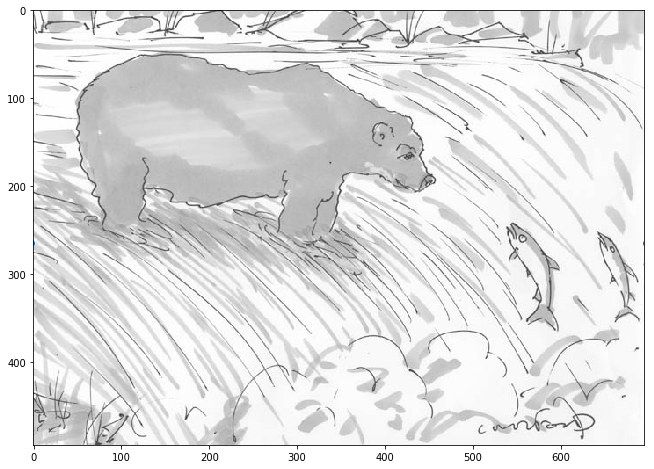

In [27]:
plt.figure(figsize=(20,8))
imgplot = plt.imshow(img)
print(description)